# central_core_J_08_07
Formerly known as March21_2022_AB.ipynb

## Signal extraction and model fitting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# User-configurable information about the cube
from astropy import units as u
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/'
freq_spw = '146_spw51'
fmin = 147.035*u.GHz
fmax = 147.175*u.GHz

In [3]:
# Import the cube
from spectral_cube import SpectralCube
cube = SpectralCube.read(results+'source_ab_'+freq_spw+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.image')

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/casa_formats_io-0.1-py3.7-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [4]:
# Get region for central core
import regions
reg = regions.Regions.read('centralcoreellipse.reg')

In [5]:
# Create a subcube cutout from that central core region
scube = cube.subcube_from_regions(reg)
scube

DaskVaryingResolutionSpectralCube with shape=(3840, 17, 17) and unit=Jy / beam and chunk size (128, 10, 17):
 n_x:     17  type_x: RA---SIN  unit_x: deg    range:   266.543777 deg:  266.544790 deg
 n_y:     17  type_y: DEC--SIN  unit_y: deg    range:   -28.705319 deg:  -28.704431 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 145582599820.702 Hz:147457166014.871 Hz

/blue/adamginsburg/abulatek/anaconda/lib/python3.7/site-packages/radio_beam-0.3.3-py3.7.egg/radio_beam/multiple_beams.py:265: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


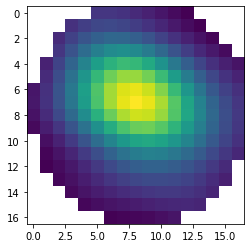

In [6]:
# Get the moment 0 map for the 0 and 1 components of the subcube
m0 = scube.spectral_slab(147.15*u.GHz, 147.156*u.GHz).moment0() # Frequencies estimated by eye?
m0.quicklook()

In [7]:
# Extract the spectrum for the brightest pixel in the moment 0 map
import numpy as np
brightest_pixel = np.unravel_index(np.nanargmax(m0), m0.shape)
spec_for_max_pixel = scube[:, brightest_pixel[0], brightest_pixel[1]]
spec_for_max_pixel

<VaryingResolutionOneDSpectrum [-0.0099265 ,-0.00536276,-0.01005733,...,
                                 0.01596251, 0.0141059 , 0.01227994] Jy / beam>

In [8]:
# Get conversion factor to convert spectrum from Jy/beam to K
jtok = spec_for_max_pixel.beams.common_beam().jtok(spec_for_max_pixel.spectral_axis).mean()

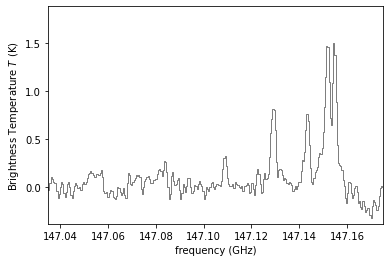

In [9]:
# Put spectrum into pyspeckit, including continuum subtraction
import pyspeckit
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters, generate_fitter
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.model import SpectralModel
sp = pyspeckit.Spectrum(data = (spec_for_max_pixel - np.median(spec_for_max_pixel.quantity)) * jtok/spec_for_max_pixel.unit, 
                        xarr = spec_for_max_pixel.spectral_axis.to(u.GHz))
sp.plotter(xmin = fmin, xmax = fmax)

In [10]:
# Set up parameters for fitting
v_cen = 40*u.km/u.s
v_disp = 2*u.km/u.s
temp = 167*u.K
N_tot = 1e16*u.cm**-2

In [11]:
# Set up fitter for CH3CN lines
species = 'CH3CN'
freqs, aij, deg, EU, partfunc = get_molecular_parameters(species, fmin = fmin, fmax = fmax)
# mod = lte_molecule.generate_model(sp.xarr, v_cen, v_disp, temp, N_tot,
#                                   freqs, aij, deg, EU, partfunc)
### Why do we need to make the above model?

def modfunc(xarr, vcen, width, tex, column, fillingfactor = 1):
    if column < 100:
        column = 10**column # Cheat by being able to put column density either in log form or not
    return lte_molecule.generate_model(xarr, vcen, width, tex, column, freqs, aij, deg, EU, partfunc)*fillingfactor

fitter = SpectralModel(modfunc, 5,
            parnames=['shift','width','tex','column','ff'],
            parlimited=[(False,False),(True,False),(True,False),(True,False),(True,True)],
            parlimits=[(0,0), (0,0), (0,0),(0,0),(0,1)],
            shortvarnames=(r'v_{cen}',r'v_{disp}','T_{ex}','N_{tot}','ff'),
            centroid_par='shift',
            )
fitter.__name__ = "CH3CN"

sp.specfit.Registry.multifitters['CH3CN'] = fitter
sp.specfit.Registry.npars['CH3CN'] = 5

(-0.5, 3.0)

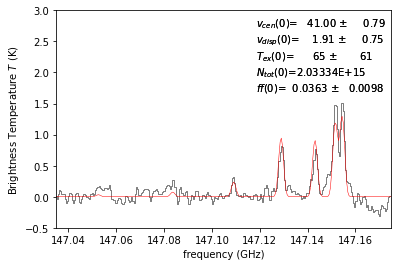

In [12]:
sp.specfit(fittype = 'CH3CN', guesses=[40.1, 1.5, 195.1, 1e16, 1], use_lmfit = False) # Used to be True; kernel didn't recognize pip install
sp.plotter(xmin = fmin, xmax = fmax)
sp.specfit.plot_fit()
sp.plotter.axis.set_ylim(-0.5, 3)

## Rotational diagram fitting of central core maximum

In [13]:
# Get noise level for spectrum
from astropy.stats import mad_std
noise_level = mad_std(sp.data)*u.K
print(noise_level)

0.07060011248127701 K


In [14]:
# Measure and convert integrated intensities
from pyspeckit.spectrum.models.lte_molecule import nupper_of_kkms

log_N_upper_gs = []
log_N_upper_g_errs = []

plots = False

kmax = len(freqs) - 1 # Maximum rotational quantum number for the ladder
for i in range(len(freqs)): # i is the index of the loop
    kk = kmax - i # Get rotational quantum number of this iteration
    
    if kk == 0 or kk == 1:
        # Center spectrum on k = 0 component, extract, then convert new spectrum to GHz
        sp.xarr.convert_to_unit(u.km/u.s, refX = freqs[kmax - 0], velocity_convention = 'radio')
        new_sp_0 = sp.slice(v_cen - 4.5*u.km/u.s, v_cen + 4.5*u.km/u.s)
        new_sp_0.xarr.convert_to_unit(u.GHz, refX = freqs[kmax - 0], velocity_convention = 'radio')
        print(f"k = 0: {np.min(new_sp_0.xarr)}, {np.max(new_sp_0.xarr)}")
        if plots == True:
            new_sp_0.plotter()
        # Convert the original spectrum back to frequency units (doing this twice preserves the spectrum... maybe?)
        sp.xarr.convert_to_unit(u.GHz, refX = freqs[kmax - 0], velocity_convention = 'radio')
        
        # Center spectrum on k = 1 component, extract
        sp.xarr.convert_to_unit(u.km/u.s, refX = freqs[kmax - 1], velocity_convention = 'radio')
        new_sp_1 = sp.slice(v_cen - 4.5*u.km/u.s, v_cen + 4.5*u.km/u.s)
        new_sp_1.xarr.convert_to_unit(u.GHz, refX = freqs[kmax - 1], velocity_convention = 'radio')
        print(f"k = 1: {np.min(new_sp_1.xarr)}, {np.max(new_sp_1.xarr)}")
        if plots == True:
            new_sp_1.plotter()
        # Convert the original spectrum back to frequency units (doing this twice preserves the spectrum... maybe?)
        sp.xarr.convert_to_unit(u.GHz, refX = freqs[kmax - 1], velocity_convention = 'radio')

        # Get frequency range we want: highest freq in k = 1, highest freq in k = 0
        highest_freq_1 = np.max(new_sp_1.xarr)
        highest_freq_0 = np.max(new_sp_0.xarr)
        # Get extra part of k = 0 that's not in k = 1 cube
        extra_part_of_0 = new_sp_0.slice(highest_freq_1, highest_freq_0)
        print(f"Part of k = 0 that's not in k = 1: {np.min(extra_part_of_0.xarr)}, {np.max(extra_part_of_0.xarr)}")
        if plots == True:
            extra_part_of_0.plotter()
        # Convert back to velocities for correct units in mom0 map
        extra_part_of_0.xarr.convert_to_unit(u.km/u.s, refX = freqs[kmax - 0], velocity_convention = 'radio')
        new_sp_1.xarr.convert_to_unit(u.km/u.s, refX = freqs[kmax - 1], velocity_convention = 'radio')

        # Calculate integrated intensity (sum slice and multiply by channel width)
        slice_sum_0 = extra_part_of_0.data.sum()*u.K
        slice_sum_1 = new_sp_1.data.sum()*u.K
        channel_width = np.abs(new_sp_1.xarr.cdelt())
        mom0_sum = (slice_sum_0 + slice_sum_1)*channel_width
        # Split equally between k = 0 and k = 1 component
        mom0 = mom0_sum/2.
    else: 
        # Center spectrum on k = 0 component, extract
        sp.xarr.convert_to_unit(u.km/u.s, refX = freqs[kmax - kk], velocity_convention = 'radio')
        new_sp = sp.slice(v_cen - 4.5*u.km/u.s, v_cen + 4.5*u.km/u.s)
        ## print(f"Plot for k = {kk}:")
        ## new_sp.plotter()
        # Calculate integrated intensity (sum slice and multiply by channel width)
        slice_sum = new_sp.data.sum()*u.K
        channel_width = np.abs(new_sp.xarr.cdelt())
        mom0 = slice_sum*channel_width

        # Convert the original spectrum back to frequency units
        sp.xarr.convert_to_unit(u.GHz, refX = freqs[kmax - kk], velocity_convention = 'radio')

    # Calculate upper state column density from integrated intensity, convert to logscale, and export
    N_upper = nupper_of_kkms(mom0, freqs[kmax - kk], 10**aij[kmax - kk]) # If I don't do 10**aij[kmax - kk], I get nans
    log_N_upper_g = np.log10(N_upper.value/deg[kmax - kk])
    # Propagate error
    noise_map_int = noise_level*channel_width
    N_upper_err = nupper_of_kkms(noise_map_int, freqs[kmax - kk], 10**aij[kmax - kk])
    log_N_upper_g_err = N_upper_err/(N_upper*np.log(10.)) 
    
    log_N_upper_gs.append(log_N_upper_g)
    log_N_upper_g_errs.append(log_N_upper_g_err)
    
log_N_upper_gs = np.array(log_N_upper_gs)
log_N_upper_g_errs = np.array(log_N_upper_g_errs)

k = 0: 147.15295795574994 GHz, 147.15686431926997 GHz
k = 1: 147.15002818310992 GHz, 147.15393454662996 GHz
Part of k = 0 that's not in k = 1: 147.15393454662996 GHz, 147.15637602382992 GHz
k = 0: 147.15295795574994 GHz, 147.15686431926997 GHz
k = 1: 147.15002818310992 GHz, 147.15393454662996 GHz
Part of k = 0 that's not in k = 1: 147.15393454662996 GHz, 147.15637602382992 GHz


In [15]:
# Convert to natural log for fitting
ln_N_upper_gs = np.log(10**(log_N_upper_gs))
ln_N_upper_g_errs = np.log(10**(log_N_upper_g_errs))

# Note to self: do not reverse EU; we are looping over frequency now, 
# and in temperature map, we were looping over k-component index
print("Energies:", EU)
print("Column densities:", ln_N_upper_gs)

Energies: [5.26838987e-14 3.98795720e-14 2.90402001e-14 2.01682662e-14
 1.32657764e-14 8.33429995e-15 5.37496915e-15 4.38845933e-15]
Column densities: [21.75172929 22.4816495  22.91259898 22.77153811 23.17144014 23.61411716
 24.24983497 24.23383848]


In [16]:
from scipy.optimize import curve_fit
from astropy import constants

def linear(x, m, b):
    return m*x + b

# Do the simple linear fit
EU_converted = (EU*u.erg/constants.k_B).decompose()

good_energy_filter = EU_converted < 180*u.K

EU_converted = EU_converted[good_energy_filter]
ln_N_upper_gs = ln_N_upper_gs[good_energy_filter]
ln_N_upper_g_errs = ln_N_upper_g_errs[good_energy_filter]

# Note to self: convert to K from ergs to do the fit, because in ergs, 
# these energies are small numbers, and that can makes the fit not works
popt, pcov = curve_fit(linear, EU_converted, ln_N_upper_gs, sigma = ln_N_upper_g_errs)
slope, intercept = popt[0], popt[1]
temp_fit = (-1./slope)*u.K
N_tot_fit = np.log10(np.exp(intercept)*partfunc(temp_fit))

In [17]:
plt.rcParams['figure.facecolor'] = 'w' # Sometimes I have to re-run this? So I'm moving it down here

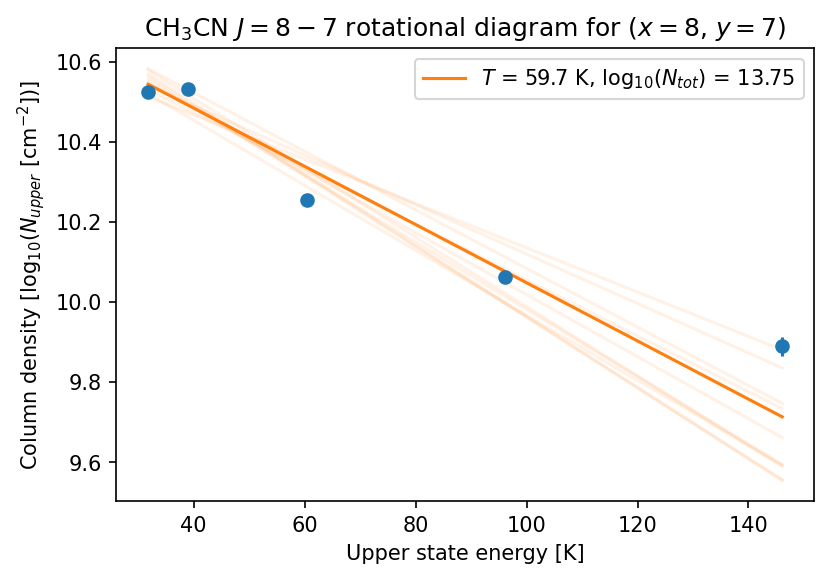

In [22]:
plot_uncertainties = True

plt.figure(dpi = 150)
# plt.scatter(EU_converted, np.log10(np.exp(ln_N_upper_gs)), color = 'tab:blue')
plt.errorbar(EU_converted, np.log10(np.exp(ln_N_upper_gs)), yerr = np.log10(np.exp(ln_N_upper_g_errs)), fmt = 'o')

plt.plot(EU_converted, np.log10(np.exp(EU_converted.value*slope+intercept)),
         color = 'tab:orange',
         label = f"$T$ = {temp_fit:.1f}, $\log_{{10}}(N_{{tot}})$ = {N_tot_fit:.2f}")

if plot_uncertainties == True:
    rng = np.random.default_rng()
    rv = rng.multivariate_normal(popt, pcov, 10)
    for param in rv:
        slope_i, intercept_i = param[0], param[1]
        temp_i = (-1./slope_i)*u.K
        total_col_density_i = np.log10(np.exp(intercept_i)*partfunc(temp_i))
        plt.plot(EU_converted, np.log10(np.exp(EU_converted.value*slope_i+intercept_i)), 
                 alpha = 0.1, color = 'tab:orange') 

plt.title(f"CH$_3$CN $J = 8 - 7$ rotational diagram for ($x = ${brightest_pixel[1]}, $y = ${brightest_pixel[0]})")
plt.xlabel(f"Upper state energy [K]")
plt.ylabel(f"Column density [$\log_{{10}}(N_{{upper}}\ [\mathrm{{cm}}^{{-2}}])$]")
plt.legend()

plt.savefig(f"rot_diagram_x{brightest_pixel[1]}y{brightest_pixel[0]}.pdf", dpi = 200, facecolor='w', edgecolor='w', bbox_inches='tight')